# Anomaly Detection Using Gaussian Distribution

_Source: 🤖[Homemade Machine Learning](https://github.com/trekhleb/homemade-machine-learning) repository_

> ☝Before moving on with this demo you might want to take a look at:
> - 📗[Math behind the Anomaly Detection](https://github.com/trekhleb/homemade-machine-learning/tree/master/homemade/anomaly_detection)
> - ⚙️[Gaussian Anomaly Detection Source Code](https://github.com/trekhleb/homemade-machine-learning/blob/master/homemade/anomaly_detection/gaussian_anomaly_detection.py)

**Anomaly detection** (also **outlier detection**) is the identification of rare items, events or observations which raise suspicions by differing significantly from the majority of the data.

The **normal** (or **Gaussian**) distribution is a very common continuous probability distribution. Normal distributions are important in statistics and are often used in the natural and social sciences to represent real-valued random variables whose distributions are not known. A random variable with a Gaussian distribution is said to be normally distributed and is called a normal deviate.

> **Demo Project:** In this demo we will build a model that will find anomalies in server operational parameters such as `Latency` and `Throughput`.

In [1]:
# To make debugging of logistic_regression module easier we enable imported modules autoreloading feature.
# By doing this you may change the code of logistic_regression library and all these changes will be available here.
%load_ext autoreload
%autoreload 2

# Add project root folder to module loading paths.
import sys
sys.path.append('../..')

### Import Dependencies

- [pandas](https://pandas.pydata.org/) - library that we will use for loading and displaying the data in a table
- [numpy](http://www.numpy.org/) - library that we will use for linear algebra operations
- [matplotlib](https://matplotlib.org/) - library that we will use for plotting the data
- [anomaly_detection](https://github.com/trekhleb/homemade-machine-learning/blob/master/homemade/anomaly_detection/gaussian_anomaly_detection.py) - custom implementation of anomaly detection using Gaussian distribution.

In [2]:
# Import 3rd party dependencies.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import custom Gaussian anomaly detection implementation.
from homemade.anomaly_detection import GaussianAnomalyDetection

### Load the Data

In this demo we will use the dataset with server operational parameters such as `Latency` and `Throughput` and will try to find anomalies in them.

In [3]:
# Load the data.
pd_data = pd.read_csv('../../data/server-operational-params.csv')

# Print the data table.
pd_data.head(10)

,Latency (ms),Throughput (mb/s),Anomaly
0,13.046815,14.741152,0
1,13.408520,13.763270,0
2,14.195915,15.853181,0
3,14.914701,16.174260,0
4,13.576700,14.042849,0
5,13.922403,13.406469,0
6,12.822132,14.223188,0
7,15.676366,15.891691,0
8,16.162875,16.202998,0
9,12.666451,14.899084,1


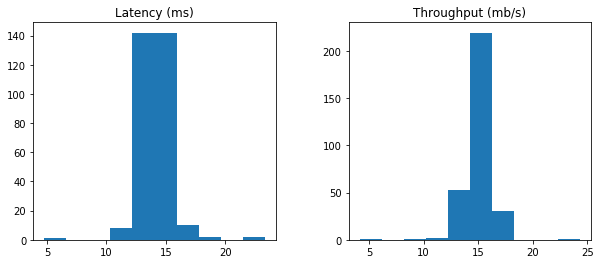

In [4]:
# Print histograms for each feature to see how they vary.
histohrams = pd_data[['Latency (ms)', 'Throughput (mb/s)']].hist(grid=False, figsize=(10,4))

### Plot the Data

Let's plot `Throughput(Latency)` dependency and see if the distribution is similar to Gaussian one.

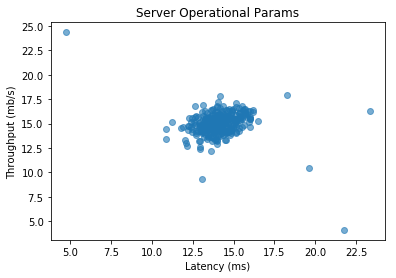

In [5]:
# Extract first two column from the dataset.
data = pd_data[['Latency (ms)', 'Throughput (mb/s)']].values

# Plot the data.
plt.scatter(data[:, 0], data[:, 1], alpha=0.6)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Server Operational Params')
plt.show()

### Find Anomalies Using Gaussian Distribution

Let's try to use our custom anomaly detection implementation using Gaussian distribution.

In [6]:
# Init Gaussian anomaly instance.
gaussian_anomaly = GaussianAnomalyDetection(data)

# Let's see Gaussian estimation parameters.
print('mu')
print(gaussian_anomaly.mu_param)

print('\n')

print('sigma^2')
print(gaussian_anomaly.sigma_squared)

mu
[14.11222578 14.99771051]


sigma^2
[1.83263141 1.70974533]


### Visualize the Fit

Let's draw a contour plots that will represent our Gaussian distribution for the dataset.

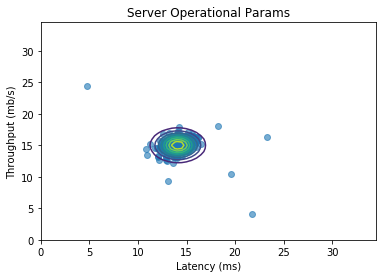

In [7]:
# Create a 3D grid to build a contour plots.

# Create ranges along X and Y axes.
latency_from = 0
latency_to = 35

throughput_from = 0
throughput_to = 35

step = 0.5

latency_range = np.arange(latency_from, latency_to, step)
throughput_range = np.arange(throughput_from, throughput_to, step)

# Create X and Y grids.
(latency_grid, throughput_grid) = np.meshgrid(latency_range, throughput_range)

# Flatten latency and throughput grids.
flat_latency_grid = latency_grid.flatten().reshape((latency_grid.size, 1))
flat_throughput_grid = throughput_grid.flatten().reshape((throughput_grid.size, 1))

# Joing latency and throughput flatten grids together to form all combinations of latency and throughput.
combinations = np.hstack((flat_latency_grid, flat_throughput_grid))

# Now let's calculate the probabilities for every combination of latency and throughput.
flat_probabilities = gaussian_anomaly.multivariate_gaussian(combinations)

# Resghape probabilities back to matrix in order to build contours.
probabilities = flat_probabilities.reshape(latency_grid.shape)

# Let's build plot our original dataset.
plt.scatter(data[:, 0], data[:, 1], alpha=0.6)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Server Operational Params')

# On top of our original dataset let's plot probability contours.
plt.contour(latency_grid, throughput_grid, probabilities, levels=10)

# Display the plot.
plt.show()

### Select best threshold

Now, in order to decide which examples should be counted as an anomaly we need to decide which probability threshold to choose. We could do it intuitively but since we have all data examples labeled in our dataset let's use that data to calculate the best threshold.

In [8]:
# Extract the information about which example is anomaly and which is not.
num_examples = data.shape[0]
labels = pd_data['Anomaly'].values.reshape((num_examples, 1))

# Returns the density of the multivariate normal at each data point (row) of X dataset.
probabilities = gaussian_anomaly.multivariate_gaussian(data)

# Let's go through many possible thresholds and pick the one with the highest F1 score.
(epsilon, f1, precision_history, recall_history, f1_history) = gaussian_anomaly.select_threshold(
    labels, probabilities
)

print('Best epsilon:')
print(epsilon)

print('\n')

print('Best F1 score:')
print(f1)

Best epsilon:
8.986095083415364e-05


Best F1 score:
0.8


### Plot Precision/Recall Progress

Let's now plot precision, reacall and F1 score changes for every iteration.

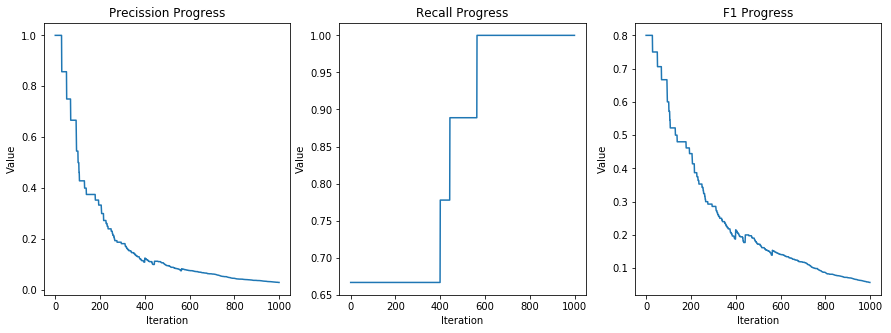

In [9]:
# Make the plot a little bit bigger than default one.
plt.figure(figsize=(15, 5))

# Plot precission history.
plt.subplot(1, 3, 1)
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Precission Progress')
plt.plot(precision_history)

# Plot recall history.
plt.subplot(1, 3, 2)
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Recall Progress')
plt.plot(recall_history)

# Plot F1 history.
plt.subplot(1, 3, 3)
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('F1 Progress')
plt.plot(f1_history)

# Display all plots.
plt.show()

### Fing Outliers

Since now we have calculated best `epsilon` we may find outliers.

[]

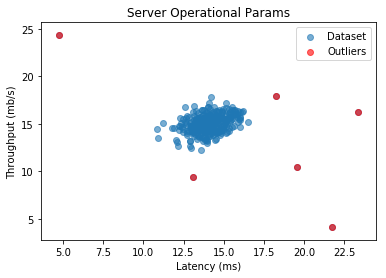

In [10]:
# Find indices of data examples with probabilities less than the best epsilon.
outliers_indices = np.where(probabilities < epsilon)[0]

# Plot original data.
plt.scatter(data[:, 0], data[:, 1], alpha=0.6, label='Dataset')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Server Operational Params')

# Plot the outliers.
plt.scatter(data[outliers_indices, 0], data[outliers_indices, 1], alpha=0.6, c='red', label='Outliers')

# Display plots.
plt.legend()
plt.plot()